In [ ]:
import torch
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

In [ ]:
pip install cupy-cuda11x

In [7]:
import numpy as np

def S_fft(Z):
    N = Z.shape[0]
    Y = np.zeros((Z.shape[1], N // 2 + 1))

    for i in range(Z.shape[1]):
        Z_T = Z[:, i].T  # Transpose the i-th column of Z
        FF = np.fft.fft(Z_T)  # Compute FFT of F
        PFF = np.abs((FF / N) ** 2)  # Power spectrum

        # Fill in the power spectrum up to N/2+1
        Y[i, :] = PFF[:N // 2 + 1]
        # Double the values for all but the first and last elements to account for negative frequencies
        Y[i, 1:-1] *= 2

    # Transpose Y for final output
    F_output = Y.T
    return F_output

import cupy as cp

def S_fft_gpu(Z):
    N = Z.shape[0]
    Y = cp.zeros((Z.shape[1], N // 2 + 1), dtype=cp.float32)

    # Move the data to the GPU
    Z_gpu = cp.array(Z)

    for i in range(Z_gpu.shape[1]):
        Z_T = Z_gpu[:, i].T  # Transpose the i-th column of Z
        FF = cp.fft.fft(Z_T)  # Compute FFT on GPU
        PFF = cp.abs((FF / N) ** 2)  # Power spectrum on GPU

        # Fill in the power spectrum up to N/2+1
        Y[i, :] = PFF[:N // 2 + 1]
        # Double the values for all but the first and last elements to account for negative frequencies
        Y[i, 1:-1] *= 2

    # Transpose Y for final output
    F_output = Y.T
    return cp.asnumpy(F_output)  # Convert back to a NumPy array if needed on CPU


ModuleNotFoundError: No module named 'cupy'

# toy gpu

In [3]:
#for TA1

import cupy as cp
import os
from scipy.io import savemat
import time

def TOY_test(image_number):
    start_time = time.time()

    # Constants
    c = 3 / 100  # Speed of light

    # Number of vibrational modes
    N_vibr = np.random.randint(3, 7)  # 3 to 6 modes

    # Pulse frequencies
    w_ca = cp.random.choice(cp.arange(150, 1601), N_vibr, replace=False)

    # Dephasing rates
    g_ca = 0.1 + 2.9 * cp.random.rand(N_vibr)

    # Chirp
    C = cp.random.rand() * 1000 * 1e-6  # from ps^2 to fs^2

    # Probe parameters
    w_p = 20000
    w_r = 15000
    T_p = 1 * 1e-3  # ps
    sig_p = T_p / (2 * cp.sqrt(2 * cp.log(2))) * cp.sqrt(2)
    I_p = 1e3

    def E_p(w):
        return cp.sqrt(I_p) * cp.exp(-(sig_p**2 * ((w - w_p) * 2 * cp.pi * c) ** 2) / 2)

    # Photon count and noise
    N_count_base = int((1 / 4) * 1e4)
    wmin, wmax = 15000, 22000
    N_dots_w = 1300  # frequency points w
    w = cp.linspace(wmin, wmax, N_dots_w)
    
    # Arrays
    N_dots_T = 1600
    Delta_T_Ny = 1 / (2 * 1600 * c) / 4  # n times Nyquist frequency
    Tmin = (w_p - cp.max(w)) * 4 * cp.pi * c * C  # till the mask end
    Tmax = Tmin + Delta_T_Ny * N_dots_T
    T = cp.linspace(Tmin, Tmax, N_dots_T)
    print(f"Tmin={Tmin}, Tmax={Tmax}, N_dots_T={N_dots_T}")

    # Cross-sections
    perc_RG = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 170, 200]) #test levels
    RG_ivs = np.array([1e-3/2])
    RG_a = cp.ones(N_vibr)
    RG_b = cp.ones(N_vibr)

    # Noise parameters
    A_r_mu = 1e6
    A_r_std_base = A_r_mu / 50

    # Acquisition settings
    N_acq = 100  
    N_count = N_count_base * N_acq
    A_r_std = A_r_std_base / cp.sqrt(N_acq)

    def A_a(w, w_ca):
        return E_p(w - w_ca)
    def A_b(w, w_ca):
        return E_p(w + w_ca)
    
    # TA parameters
    W = [16500, 16600, 20000]
    G = [1000 + 1000 * cp.random.rand() for _ in range(3)]
    sig = cp.array(G) / (2 * cp.sqrt(2 * cp.log(2)))
    k_ta = cp.asarray([1] * 3) * cp.random.rand(1)  # Adjusted to use CuPy
    g_ta = [0.1 * cp.random.rand() for _ in range(3)]
    RG_ta = [1, 1, 2]
    RG_ta_2 = 1e-1 / 2

    # Normalization
    norm = 1
    diff = 1
    mode = "res"
    
    s = np.random.choice([-1, 1])
    a = 0.003
    if mode=="off":
        phi_a = lambda w, w_ca: cp.pi / 2
        phi_b = lambda w, w_ca: cp.pi / 2 + cp.pi
    if mode=="res":
        phi_a = lambda w, w_ca: cp.pi * (1 - 1 / (1 + cp.exp(-a * (w - w_p - w_ca)))) + cp.pi / 2 * s
        phi_b = lambda w, w_ca: cp.pi / (1 + cp.exp(-a * (w - w_p + w_ca))) + cp.pi / 2 * s

    for i in range(len(perc_RG)):
            
        current_RG = RG_ivs*10/perc_RG[i]  #update cross-section
        #print(f"Index: {i}, perc_RG[i]: {perc_RG[i].item()}, current_RG: {current_RG}")
        
        # Generate the signal with noise and ground truth
        Z, Z_gt, Z_inter = S_TOY(w, T, w_p, w_ca, W, g_ca, G, sig, g_ta, k_ta, C,
                                 E_p, N_count, 1, A_r_mu, A_r_std,
                                 RG_a, RG_b, current_RG, RG_ta, RG_ta_2, 1, A_a, phi_a,
                                 A_b, phi_b, norm, diff, mode)
        
        # Mask for the artifact
        Z = cp.asarray(Z)
        Z_gt = cp.asarray(Z_gt)
        Z_inter = cp.asarray(Z_inter)
        mask = cp.ones((len(T), len(w)))
        threshold_T = (w - w_p) * 4 * cp.pi * c * C
        for j in range(len(w)):
            mask[:, j] = (T + threshold_T[j]) >= 0
        Z *= mask
        Z_gt *= mask
        Z_inter *= mask

        # Save results based on mode
        if mode == "res":
            noisy_folder_path = os.path.expanduser(f"Dataset/TA/TA1/test/perc{perc_RG[i]}/noisy")
            truth_folder_path = os.path.expanduser(f"Dataset/TA/TA1/test/perc{perc_RG[i]}/label")
            os.makedirs(noisy_folder_path, exist_ok=True)
            os.makedirs(truth_folder_path, exist_ok=True)

            savemat(os.path.join(noisy_folder_path, f"S_{image_number}.mat"), {'noisy': Z.get()})
            savemat(os.path.join(truth_folder_path, f"S_{image_number}.mat"), {'label': Z_inter.get()})
                
        elif mode == "off":
            noisy_folder_path = os.path.expanduser(f"Dataset/off/test/perc{perc_RG[i]}/noisy")
            truth_folder_path = os.path.expanduser(f"Dataset/off/test/perc{perc_RG[i]}/label")
            os.makedirs(noisy_folder_path, exist_ok=True)
            os.makedirs(truth_folder_path, exist_ok=True)

            savemat(os.path.join(noisy_folder_path, f"S_{image_number}.mat"), {'noisy': Z.get()})
            savemat(os.path.join(truth_folder_path, f"S_{image_number}.mat"), {'label': Z_gt.get()})

        elapsed_time = time.time() - start_time
        print(f"Data for graph {image_number}, RG_ivs {perc_RG[i]}% saved in {elapsed_time:.2f} seconds.")


In [4]:
import numpy as np
import cupy as cp

def S_TOY(w, T, w_p, w_ca, W, g_ca, G, sig, g_ta, k_ta, 
          C, E_p, N_count, kost, mu_A_r, std_A_r, RG_a, RG_b, 
          RG_ivs, RG_ta, RG_ta_2, N_acq, A_a, phi_a, A_b, phi_b, 
          norm, diff, mode):
    
    # Speed of light
    c = 3 / 100

    # Convert inputs to CuPy arrays
    w, T, w_ca, W, g_ca, G, sig, g_ta, k_ta = [cp.asarray(arr) for arr in (w, T, w_ca, W, g_ca, G, sig, g_ta, k_ta)]
    C, RG_a, RG_b, RG_ivs, RG_ta, RG_ta_2 = map(cp.asarray, [C, RG_a, RG_b, RG_ivs, RG_ta, RG_ta_2])

    # Define signal functions with CuPy
    def DT(w, T, w_vib):
        return T + (w - w_p + w_vib) * 4 * cp.pi * c * C

    a = 1e2
    def f_c(T, w, w_vib):
        return 1 / (cp.exp(-a * DT(w, T, w_vib/2)) + 1)

    def toy(w, T, w_ca, A, ph):
        return cp.sin(cp.abs(w_ca) * 2 * cp.pi * c * DT(w, T, w_ca) + ph) * A * f_c(T, w, w_ca)

    def f_E_3(w, T, RG_a, RG_b, w_ca, g_ca, A_a, ph_a, A_b, ph_b):
        return (RG_a * toy(w, T, -w_ca, A_a, ph_a) + RG_b * toy(w, T, +w_ca, A_b, ph_b)) * cp.exp(-g_ca * DT(w, T, w_ca))

    def PV(w, W, G, sig, k_ta):
        return (G / 2) ** 2 / ((w - W) ** 2 + (G / 2) ** 2) * k_ta + cp.exp(-(w - W) ** 2 / (2 * sig ** 2)) * (1 - k_ta)

    def f_E_ta(w, T, W, G, sig, k_ta, g_ta, RG_ta):
        return (
            RG_ta[0] * PV(w, W[0], G[0], sig[0], k_ta[0]) * cp.exp(-g_ta[0] * DT(w, T, 0)) +
            RG_ta[1] * PV(w, W[1], G[1], sig[1], k_ta[1]) * cp.exp(-g_ta[1] * DT(w, T, 0)) -
            RG_ta[2] * PV(w, W[2], G[2], sig[2], k_ta[2]) * cp.exp(-g_ta[2] * DT(w, T, 0))
        ) * f_c(T, w, 0)

    # Initialize photon number arrays on GPU
    N_0_gt = cp.zeros((len(w), len(T)))
    N_s_gt1 = cp.zeros((len(w), len(T)))
    N_s_gt2 = cp.zeros((len(w), len(T)))
    N_s_n = cp.zeros((len(w), len(T)))
    N_0_n = cp.zeros((len(w), len(T)))

    # Create grids for w, T, and w_ca
    W_grid, T_grid, W_ca_grid = cp.meshgrid(w, T, w_ca, indexing='ij')

    # Compute A_a, phi_a, A_b, phi_b in vectorized form
    A_a_vals = A_a(W_grid, W_ca_grid)
    phi_a_vals = phi_a(W_grid, W_ca_grid)
    A_b_vals = A_b(W_grid, W_ca_grid)
    phi_b_vals = phi_b(W_grid, W_ca_grid)

    # Reshape RG_a, RG_b, and g_ca for broadcasting
    RG_a_vals = RG_a.reshape((1, 1, -1))
    RG_b_vals = RG_b.reshape((1, 1, -1))
    g_ca_vals = g_ca.reshape((1, 1, -1))

    # Compute E_3 values in vectorized form
    E_3_vals = f_E_3(W_grid, T_grid, RG_a_vals, RG_b_vals, W_ca_grid, g_ca_vals, A_a_vals, phi_a_vals, A_b_vals, phi_b_vals)

    # Sum along the third dimension (w_ca) to get the final result
    E_ivs = cp.sum(E_3_vals, axis=2)

    # Element-wise operation
    E_p_broadcast = cp.tile(E_p(w), (len(T), 1)).T
    
    # Normalize the signal
    if mu_A_r!=0 and cp.max(cp.abs(E_ivs))!=0:
        E_ivs = E_ivs / cp.max(cp.abs(E_ivs)) * cp.max(E_p_broadcast)
        RG_ivs = RG_ivs / mu_A_r / 2 

    # TA calculation if mode is "res"
    if mode == "res":
        W_grid_ta, T_grid_ta = cp.meshgrid(w, T, indexing='ij')
        E_ta = f_E_ta(W_grid_ta, T_grid_ta, W, G, sig, k_ta, g_ta, RG_ta)
        
        # Normalize the signal
        if mu_A_r!=0 and cp.max(cp.abs(E_ta))!=0:
            E_ta = E_ta / cp.max(cp.abs(E_ta)) * cp.max(E_p_broadcast)
            RG_ta_2 = RG_ta_2 / mu_A_r / 2 

    for _ in range(N_acq):
        A_r = cp.abs(mu_A_r + std_A_r * cp.random.randn(1, len(T)))

        if mode == "off":
            N_0_gt += N_count * cp.abs(E_p_broadcast) ** 2
            N_0_n += cp.random.poisson(N_count * cp.abs(E_p_broadcast) ** 2)
            N_s_gt1 += N_count * ( mu_A_r*cp.abs(RG_ivs*E_ivs)**2 + cp.abs(E_p_broadcast)**2 + 2*mu_A_r*cp.real(RG_ivs*E_ivs*cp.conj(E_p_broadcast)) )
            N_s_n += cp.random.poisson( N_count * ( A_r*cp.abs(RG_ivs*E_ivs)**2 + cp.abs(E_p_broadcast)**2 + 2*A_r*cp.real(RG_ivs*E_ivs*cp.conj(E_p_broadcast)) ) )
            
        elif mode == "res":
            N_0_gt += N_count * cp.abs(E_p_broadcast) ** 2
            N_0_n += cp.random.poisson(N_count * cp.abs(E_p_broadcast) ** 2)
            N_s_gt1 += N_count * ( mu_A_r*cp.abs(RG_ta_2*E_ta)**2 + cp.abs(E_p_broadcast)**2 + 2*mu_A_r*cp.real(RG_ta_2*E_ta*cp.conj(E_p_broadcast)) )
            N_s_gt2 += N_count * ( mu_A_r*cp.abs(RG_ivs*E_ivs)**2 + cp.abs(E_p_broadcast)**2 + 2*mu_A_r*cp.real(RG_ivs*E_ivs*cp.conj(E_p_broadcast)) )
            N_s_n += cp.random.poisson( N_count * ( A_r*cp.abs(RG_ivs*E_ivs+RG_ta_2*E_ta)**2 + cp.abs(E_p_broadcast)**2 + 2*A_r*cp.real((RG_ivs*E_ivs+RG_ta_2*E_ta)*cp.conj(E_p_broadcast)) ) )

    # Compute means
    N_0_gt /= N_acq
    N_s_gt1 /= N_acq
    N_s_gt2 /= N_acq
    N_0_n /= N_acq
    N_s_n /= N_acq

    # Normalize or subtract
    if norm == 0 and diff == 0:
        I_s_gt1 = kost * N_s_gt1
        I_s_gt2 = kost * N_s_gt2
        I_s_n = kost * N_s_n
    elif norm == 0 and diff == 1:
        I_s_gt1 = kost * (N_s_gt1 - N_0_gt)
        I_s_gt2 = kost * (N_s_gt2 - N_0_gt)
        I_s_n = kost * (N_s_n - N_0_n)
    elif norm == 1 and diff == 0:
        I_s_gt1 = N_s_gt1 / N_0_gt
        I_s_gt2 = N_s_gt2 / N_0_gt
        I_s_n = N_s_n / N_0_n
    elif norm == 1 and diff == 1:
        I_s_gt1 = N_s_gt1 / N_0_gt - 1
        I_s_gt2 = N_s_gt2 / N_0_gt - 1
        I_s_n = N_s_n / N_0_n - 1
    else:
        raise ValueError('Invalid values for "norm" and "diff"')

    # Output results
    if mode == "off":
        Z_n = I_s_n.T
        Z_inter = Z_n
        Z_gt = I_s_gt1.T
    elif mode == "res":
        Z_n = I_s_n.T
        Z_inter = (I_s_n - I_s_gt1).T
        Z_gt = I_s_gt2.T
        
    #print(f'max:{cp.max(cp.abs(Z_gt))}')

    return Z_n, Z_gt, Z_inter


In [147]:
import os
import time
import cupy as cp
from scipy.io import savemat
import numpy as np
import scipy.io as sio

def TOY(image_number):
    start_time = time.time()

    # Parameters
    c = 3 / 100  # speed of light

    # Vibrational modes
    N_vibr = np.random.randint(2, 5)  # 3-6 vibrational modes

    # Pulses
    w_ca = cp.random.choice(cp.arange(400, 700+1), N_vibr, replace=False)  # select N_vibr values between 150 and 1600
    
    # Dephasing
    g_ca = 0.1 + 2.9 * cp.random.rand(N_vibr)  # range from 0.1 to 3

    # Chirp
    C = (cp.random.rand()*400+100) * 1e-6  # ps^2 to fs^2

    # pulse frequencies
    w_p = 20000
    #w_r = 15000

    # Probe amplitude
    T_p = 1 * 1e-3  # ps
    sig_p = T_p / (2 * cp.sqrt(2 * cp.log(2))) * cp.sqrt(2)  # ps
    I_p = 1e3

    def E_p(w):
        return cp.sqrt(I_p) * cp.exp(-(sig_p**2 * ((w - w_p) * 2 * cp.pi * c) ** 2) / 2)

    # Photon count and noise
    N_count = int((1 / 4) * 1e4)
    wmin, wmax = 15000, 22000
    N_dots_w = 900  # frequency points w
    #w = cp.linspace(wmin, wmax, N_dots_w)
    w = 1e7/cp.linspace(1e7/wmin, 1e7/wmax, N_dots_w)  #lambda

    N_dots_T = 200
    Delta_T_Ny = cp.random.uniform(0.010, 0.015)
    #Delta_T_Ny = 1 / (2 * 1600 * c) /2 # n times Nyquist frequency
    Tmin = (w_p - cp.max(w)) * 4 * cp.pi * c * C   #till the mask end
    Tmax = Tmin + Delta_T_Ny * N_dots_T
    T = cp.linspace(Tmin, Tmax, N_dots_T)
    print(f"Tmin={Tmin}, Tmax={Tmax}, N_dots_T={N_dots_T}")

    # Cross-sections
    RG_ivs = 1e-4 * (1 + 9 * cp.random.rand())
    RG_a = cp.ones(N_vibr)
    RG_b = cp.ones(N_vibr)

    # Noise parameters
    A_r_mu = 1e6
    A_r_std = A_r_mu / 50
    N_acq = 1
    N_acq_2 = cp.random.randint(200, 200+1)  #fixed to 100
    N_count *= N_acq_2
    A_r_std /= cp.sqrt(N_acq_2)

    def A_a(w, w_ca):
        return E_p(w - w_ca)

    def A_b(w, w_ca):
        return E_p(w + w_ca)

    # TA parameters
    W = [16500, 16600, 20000]
    G_value = 1500 + 500 * cp.random.rand()
    G = [G_value, G_value, 1.5 * (1500 + 500 * cp.random.rand())]
    sig = cp.array(G) / (2 * cp.sqrt(2 * cp.log(2)))
    k_ta = cp.asarray([1] * 3) * cp.random.rand(1)
    g_ta_value = 0.1 * cp.random.rand()
    g_ta = [g_ta_value, g_ta_value, 0.1 * cp.random.rand()]
    RG_ta = [1, 1, 2]
    RG_ta_2 = 1e-1 * (1 + 0 * cp.random.rand())

    # Normalization and difference
    norm = 1
    diff = 1
    mode = "res"

    s = np.random.choice([-1, 1])
    a = 0.003
    if mode=="off":
        phi_a = lambda w, w_ca: cp.pi / 2
        phi_b = lambda w, w_ca: cp.pi / 2 + cp.pi
    if mode=="res":
        phi_a = lambda w, w_ca: cp.pi * (1 - 1 / (1 + cp.exp(-a * (w - w_p - w_ca)))) + cp.pi / 2 * s
        phi_b = lambda w, w_ca: cp.pi / (1 + cp.exp(-a * (w - w_p + w_ca))) + cp.pi / 2 * s
    
    # Generate signal with noise and ground truth
    Z, Z_gt, Z_inter = S_TOY(w, T, w_p, w_ca, W, g_ca, G, sig, g_ta, k_ta, C, E_p, N_count, 1, A_r_mu, A_r_std, RG_a, RG_b, RG_ivs, RG_ta, RG_ta_2, N_acq, A_a, phi_a, A_b, phi_b, norm, diff, mode)

    # Mask for artifact
    mask = cp.ones((len(T), len(w)))
    threshold_T = (w - w_p) * 4 * cp.pi * c * C
    for j in range(len(w)):
        shift= 0
        mask[:, j] = (T + threshold_T[j] - shift) >= 0
    Z *= mask
    Z_gt *= mask
    Z_inter *= mask

    # Convert data back to NumPy for saving
    Z = cp.asnumpy(Z)
    Z_gt = cp.asnumpy(Z_gt)
    Z_inter = cp.asnumpy(Z_inter)

    # Save data
    if mode == "res":
        
        #noisy_folder_path = os.path.expanduser('Dataset/dt/val/noisy')
        inter_folder_path = os.path.expanduser('Dataset/dt_3/val/noisy')
        truth_folder_path = os.path.expanduser('Dataset/dt_3/val/label')

        # Create directories if they do not exist
        #os.makedirs(noisy_folder_path, exist_ok=True)
        os.makedirs(inter_folder_path, exist_ok=True)
        os.makedirs(truth_folder_path, exist_ok=True)

        # Save signals as .mat files
        #noisy_file_path = os.path.join(noisy_folder_path, f'S_{image_number}.mat')
        inter_file_path = os.path.join(inter_folder_path, f'S_{image_number}.mat')
        truth_file_path = os.path.join(truth_folder_path, f'S_{image_number}.mat')

        # Save as .mat files
        #sio.savemat(noisy_file_path, {'noisy': cp.asnumpy(Z)})  
        sio.savemat(inter_file_path, {'noisy': cp.asnumpy(Z_inter)})  
        sio.savemat(truth_file_path, {'label': cp.asnumpy(Z_gt)})  
        
    elif mode == "off":
        noisy_folder_path = os.path.expanduser('provee/noisy')#("~/condivisa/off_high/noisy")
        truth_folder_path = os.path.expanduser('provee/label')#("~/condivisa/off_high/label")
        os.makedirs(noisy_folder_path, exist_ok=True)
        os.makedirs(truth_folder_path, exist_ok=True)

        savemat(os.path.join(noisy_folder_path, f"S_{image_number}.mat"), {'noisy': Z})
        savemat(os.path.join(truth_folder_path, f"S_{image_number}.mat"), {'label': Z_gt})

    elapsed_time = time.time() - start_time
    print(f'Data for graph {image_number} saved in {elapsed_time:.2f} seconds.')


# offres

In [83]:
import cupy as cp  
import numpy as np
from scipy.special import erf

def S_offres(w, T, w_ca, w_p, g_ca, C, T_r, E_p, kost, N_count,
                 mu_I_r, std_I_r, RG_a, RG_b, RG_ivs, N_acq, norm, diff):
    
    # Configurazione di parametri su GPU
    c = 3 / 100  # cm/ps
    s_r = T_r / (2 * cp.sqrt(2 * cp.log(2))) * cp.sqrt(2)  # ps
    s_rp = 1 / s_r  # ps^-1
    ss = cp.sqrt(s_rp**2 / (1 - 4 * 1j * C * s_rp**2))  # ps^-1

    # Preallocazione di matrici
    num_w = len(w)
    num_T = len(T)
    num_ca = len(w_ca)

    # Matrici iniziali su GPU
    N_0_gt = cp.zeros((num_w, num_T))
    N_s_gt = cp.zeros((num_w, num_T))
    N_0_n = cp.zeros((num_w, num_T))
    N_s_n = cp.zeros((num_w, num_T))

    # Griglie 3D per w, T, e w_ca su GPU
    W_grid, T_grid, W_ca_grid = cp.meshgrid(w, T, w_ca, indexing='ij')

    # Calcoli preliminari su GPU
    ca_term = 1j * W_ca_grid * 2 * cp.pi * c
    T_shift_grid = T_grid + 2 * C * ((W_grid - w_p) * 2 * cp.pi * c)

    # Reshape di parametri su GPU per broadcasting
    g_ca_vals = g_ca.reshape(1, 1, num_ca)
    RG_a_vals = RG_a.reshape(1, 1, num_ca)
    RG_b_vals = RG_b.reshape(1, 1, num_ca)

    # Calcolo di M_a e M_b su GPU
    M_a_vals = (E_p(W_grid - W_ca_grid) * 
                cp.exp(-(g_ca_vals + ca_term) * T_shift_grid) * 
                cp.exp((g_ca_vals + ca_term)**2 / (4 * ss**2)))
    
    M_b_vals = (E_p(W_grid + W_ca_grid) * 
                cp.exp(-(g_ca_vals - ca_term) * T_shift_grid) * 
                cp.exp((g_ca_vals - ca_term)**2 / (4 * ss**2)))

    # Somma ponderata su RG_a e RG_b
    MM_a = cp.sum((-1j * cp.pi * M_a_vals) * RG_a_vals, axis=2)
    MM_b = cp.sum((1j * cp.pi * M_b_vals) * RG_b_vals, axis=2)

    # ERF calculation
    common_a = g_ca_vals - 2 * T_shift_grid * ss**2
    e_a = (common_a + ca_term) / (2 * ss)
    e_b = (common_a - ca_term) / (2 * ss)
    #imaginary and real parts
    x_a = cp.real(e_a)  
    y_a = cp.imag(e_a)  
    x_b = cp.real(e_b)  
    y_b = cp.imag(e_b)  

    # Calculate the ERF values
    f_a = 0
    f_b = 0
    
    N_integ=100
    dy_a = 1/N_integ*y_a*10/10
    dy_b = 1/N_integ*y_b*10/10

    for k in range(N_integ):
        ya = k/N_integ*y_a*10/10
        f_a +=  2 / cp.sqrt(cp.pi) * cp.exp(ya**2 - x_a**2) * ( cp.sin(2 * ya * x_a) + 1j * cp.cos(2 * ya * x_a) )
        yb = k/N_integ*y_b*10/10
        f_b += 2 / cp.sqrt(cp.pi) * cp.exp(yb**2 - x_b**2) * ( cp.sin(2 * yb * x_b) + 1j * cp.cos(2 * yb * x_b) )
    
    EM_a = cp.sum(1 - (erf(x_a) + f_a*dy_a), axis=2)
    EM_b = cp.sum(1 - (erf(x_b) + f_b*dy_b), axis=2)
    
    # Third-order EM field
    E_3 = -1j * (MM_a * EM_a + MM_b * EM_b) * (-1)
    
    # Element-wise operations
    E_p_broadcast = cp.tile(E_p(w), (len(T), 1)).T  # Broadcast E_p
    
    # Normalize the signal
    if mu_I_r!=0 and cp.max(cp.abs(E_3))!=0:
        RG_ivs = RG_ivs / ( 2*mu_I_r*cp.max(cp.real(E_3*cp.conj(E_p_broadcast)) / cp.abs(E_p_broadcast)**2) )
        
    for n in range(N_acq):
        # Noisy pump
        I_r = cp.abs(mu_I_r + std_I_r * cp.random.randn(1, num_T))

        # Ground truth
        N_0_gt += N_count * cp.abs(E_p_broadcast)**2
        N_s_gt += N_count * ( mu_I_r*cp.abs(RG_ivs*E_3)**2 + cp.abs(E_p_broadcast)**2 + RG_ivs*2*mu_I_r*cp.real(E_3*cp.conj(E_p_broadcast)) )

        # Noisy signals
        N_0_n += cp.random.poisson( N_count * cp.abs(E_p_broadcast)**2 )
        N_s_n += cp.random.poisson( N_count * ( I_r*cp.abs(RG_ivs*E_3)**2 + cp.abs(E_p_broadcast)**2 + 2*I_r*cp.real(E_3*cp.conj(RG_ivs*E_p_broadcast)) ) )

    # Mean
    N_0_gt /= N_acq
    N_s_gt /= N_acq
    N_0_n /= N_acq
    N_s_n /= N_acq

    # Normalization or differentiation
    if (norm == 0 and diff == 0):
        I_s_gt = kost * N_s_gt
        I_s_n = kost * N_s_n
    elif (norm == 0 and diff == 1):
        I_s_gt = kost * (N_s_gt - N_0_gt)
        I_s_n = kost * (N_s_n - N_0_n)
    elif (norm == 1 and diff == 0):
        I_s_gt = N_s_gt / N_0_gt
        I_s_n = N_s_n / N_0_n
    elif (norm == 1 and diff == 1):
        I_s_gt = N_s_gt / N_0_gt - 1
        I_s_n = N_s_n / N_0_n - 1
    else:
        raise ValueError('Error, "norm" and "diff" values are invalid.')

    # Final result
    Z_n = I_s_n.T
    Z_gt = I_s_gt.T
    
    print(f'max:{cp.max(cp.abs(Z_gt))}')

    return Z_n, Z_gt  # Porta i risultati indietro su CPU


In [94]:
import numpy as np
import os
import scipy.io as sio
import cupy as cp
import time

def offres(image_number):
    # Start timer
    start_time = time.time()

    # Parameters
    c = 3 / 100  # Speed of light in cm/ps
    N_vibr = np.random.randint(1, 1+1)  # 3 to 6 vibrational modes
    w_ca = cp.asarray(np.random.randint(200, 200+1, N_vibr))  # Vibrational frequencies
    w_p = 20000  # cm^-1

    # Dephasing
    g_ca = cp.asarray(0.1 + 0*2.9 * np.random.rand(N_vibr))  # 0.1 to 3 ps^-1

    # Chirp
    C = cp.asarray( (np.random.rand()*0+300) * 1e-6)  # Convert fs^2 to ps^2

    # Periods
    T_r = T_p = 1e-3  # Fixed period values

    # Gaussian probe pulse parameters
    s_p = T_r / (2 * np.sqrt(2 * np.log(2))) * np.sqrt(2)  # ps
    I_p = 1e3

    def E_p_0(w):
        return cp.sqrt(I_p) * cp.exp(-(s_p**2 * ((w - w_p) * 2 * np.pi * c) ** 2) / 2)

    # Number of counts
    N_count = int(1/4 * 1e4)

    # Number of acquisitions
    N_acq = 1
    N_acq_2 = cp.random.randint(100, 100+1)

    # Frequencies in cm^-1
    N_dots_w = 1300  # Number of w points
    wmin = 18000
    wmax = 22000
    w = cp.asarray(np.linspace(wmin, wmax, N_dots_w))

    # Delays in ps
    N_dots_T = 1600
    Delta_T_Ny = 1 / (2 * 1600 * c) / 4  # n times Nyquist frequency
    Tmin = (w_p - cp.max(w)) * 4 * cp.pi * c * C  # till the mask end
    Tmax = Tmin + Delta_T_Ny * N_dots_T
    T = cp.linspace(Tmin, Tmax, N_dots_T)
    print(f"Tmin={Tmin}, Tmax={Tmax}, N_dots_T={N_dots_T}")

    # Signal generation with noise
    mu_I_r =  1e6  # Mean intensity
    std_I_r = mu_I_r / 50  # Standard deviation
    
    #signal average
    N_count *= N_acq_2
    std_I_r/= cp.sqrt(N_acq_2)

    # Cross sections (example values)
    RG_ivs = 1e-4 * (1 + 9*0 * cp.random.rand())
    RG_a = 1*cp.ones(N_vibr)
    RG_b = 1*cp.ones(N_vibr)

    # Normalization
    norm = 1
    diff = 1

    # Generate signal with noise and ground truth
    Z, Z_gt = S_offres(w, T, w_ca, w_p, g_ca, C, T_r, E_p_0, 1, N_count, mu_I_r, std_I_r, RG_a, RG_b, RG_ivs, N_acq, norm, diff)

    # Maschera per l'artefatto
    mask = cp.ones((len(T), len(w)))
    threshold_T = (w - w_p) * 4 * cp.pi * c * C
    for j in range(len(w)):
        mask[:, j] = (T + threshold_T[j]) >= 0
    Z *= mask
    Z_gt *= mask
    #attenzione al caso diff!
    
    # Define paths for saving
    noisy_folder_path = os.path.expanduser('~/provee/noisy')#('~/condivisa/off_high/noisy')
    truth_folder_path = os.path.expanduser('~/provee/label')#('~/condivisa/off_high/label')

    # Create directories if they do not exist
    os.makedirs(noisy_folder_path, exist_ok=True)
    os.makedirs(truth_folder_path, exist_ok=True)

    # Save signals as .mat files
    noisy_file_path = os.path.join(noisy_folder_path, f'S_{image_number}.mat')
    truth_file_path = os.path.join(truth_folder_path, f'S_{image_number}.mat')

    # Save as .mat files
    sio.savemat(noisy_file_path, {'noisy': cp.asnumpy(Z)})  # Convert back to NumPy for saving
    sio.savemat(truth_file_path, {'label': cp.asnumpy(Z_gt)})  # Convert back to NumPy for saving

    # Display elapsed time
    elapsed_time = time.time() - start_time
    print(f'Data for graph {image_number} generated and saved in {elapsed_time:.2f} seconds.')


# resonant

In [10]:
import cupy as cp
import numpy as np

def dip(input_str, d, mode):
    Q = 1

    if mode == 'a':  # Analytical
        exp_factor = np.exp(-d**2 / 2)
        sqrt_2 = np.sqrt(2)

        if input_str == "g0e0":
            mu = exp_factor
        elif input_str == "g0e1":
            mu = -d * exp_factor
        elif input_str == "g1e0":
            mu = d * exp_factor
        elif input_str == "g1e1":
            mu = (1 - d**2) * exp_factor
        elif input_str == "g1e2":
            mu = (d**3 / sqrt_2 - d * sqrt_2) * exp_factor
        elif input_str == "g2e1":
            mu = (-d**3 / sqrt_2 + d * sqrt_2) * exp_factor
        elif input_str == "g0e2" or input_str == "g2e0":
            mu = d**2 * exp_factor / sqrt_2
        elif input_str == "e0g0":
            mu = exp_factor
        elif input_str == "e0g1":
            mu = d * exp_factor
        elif input_str == "e1g0":
            mu = -d * exp_factor
        elif input_str == "e1g1":
            mu = (1 - d**2) * exp_factor
        elif input_str == "e1g2":
            mu = (-d**3 / sqrt_2 + d * sqrt_2) * exp_factor
        elif input_str == "e2g1":
            mu = (d**3 / sqrt_2 - d * sqrt_2) * exp_factor
        elif input_str == "e0g2" or input_str == "e2g0":
            mu = d**2 * exp_factor / sqrt_2
        elif input_str == "off":  # offres
            mu = Q
        else:
            raise ValueError(f"Invalid input: {input_str}")

    elif mode == 'c':  # Computational
        # Use CuPy only for heavier computations
        sqrt_2_pi = np.sqrt(2 / np.pi)
        sqrt_pi_inv = 1 / np.sqrt(np.pi)

        if input_str == "g0e0":
            f = lambda z: sqrt_2_pi * np.exp(-(z**2 + (z - d)**2))
        elif input_str == "g0e1":
            f = lambda z: sqrt_2_pi * 2 * np.exp(-(z**2 + (z - d)**2)) * (z - d)
        elif input_str == "g1e0":
            f = lambda z: sqrt_2_pi * 2 * np.exp(-(z**2 + (z - d)**2)) * z
        elif input_str == "g1e1":
            f = lambda z: sqrt_2_pi * 4 * np.exp(-(z**2 + (z - d)**2)) * z * (z - d)
        elif input_str == "g1e2":
            f = lambda z: sqrt_pi_inv * 2 * np.exp(-(z**2 + (z - d)**2)) * (4 * (z - d)**2 - 1) * z
        elif input_str == "g2e1":
            f = lambda z: sqrt_pi_inv * 2 * np.exp(-(z**2 + (z - d)**2)) * (4 * z**2 - 1) * (z - d)
        elif input_str == "g0e2" or input_str == "g2e0":
            f = lambda z: sqrt_pi_inv * np.exp(-(z**2 + (z - d)**2)) * (4 * (z - d)**2 - 1)
        elif input_str == "e0g0":
            f = lambda z: sqrt_2_pi * np.exp(-(z**2 + (z + d)**2))
        elif input_str == "e0g1":
            f = lambda z: sqrt_2_pi * 2 * np.exp(-(z**2 + (z + d)**2)) * (z + d)
        elif input_str == "e1g0":
            f = lambda z: sqrt_2_pi * 2 * np.exp(-(z**2 + (z + d)**2)) * z
        elif input_str == "e1g1":
            f = lambda z: sqrt_2_pi * 4 * np.exp(-(z**2 + (z + d)**2)) * z * (z + d)
        elif input_str == "e1g2":
            f = lambda z: sqrt_pi_inv * 2 * np.exp(-(z**2 + (z + d)**2)) * (4 * (z + d)**2 - 1) * z
        elif input_str == "e2g1":
            f = lambda z: sqrt_pi_inv * 2 * np.exp(-(z**2 + (z + d)**2)) * (4 * z**2 - 1) * (z + d)
        elif input_str == "e0g2" or input_str == "e2g0":
            f = lambda z: sqrt_pi_inv * np.exp(-(z**2 + (z + d)**2)) * (4 * (z + d)**2 - 1)
        else:
            raise ValueError(f"Invalid input: {input_str}")

        # Use CuPy for integration
        z = np.linspace(-10, 10, 1000)
        mu = np.trapz(f(z), z)

        if input_str == "off":  # offres
            mu = Q

    else:
        raise ValueError(f"Invalid mode: {mode}")

    return mu


In [11]:
import cupy as cp

def P_res(w, T, w_r, s_eff_r, w_eg0, w_eg1, w_g1g0, g_eg0, g_eg1, g_g1g0, E_p, E_r, mu, RG_a, RG_b):
    c = 3 / 100  # cm/ps

    # Initialize matrices for polarizations
    P_a = cp.zeros((len(w), len(T)), dtype=cp.complex_)
    P_b = cp.zeros((len(w), len(T)), dtype=cp.complex_)

    # Integration points
    Nw1 = 5
    ND = 60
    M = 30

    # Precompute parameters for vibrational coherence and dephasing
    wte_a = w_eg0 - 1j * g_eg0 / (2 * cp.pi * c)
    wtg_a = w_g1g0 - 1j * g_g1g0 / (2 * cp.pi * c)
    wte_b_I = -w_eg0 - 1j * g_eg0 / (2 * cp.pi * c)
    wte_b_P = w_eg1 - 1j * g_eg1 / (2 * cp.pi * c)
    wtg_b = -w_g1g0 - 1j * g_g1g0 / (2 * cp.pi * c)

    # Generate grid for w and T
    W, T_grid = cp.meshgrid(w, T, indexing='ij')

    # Loop over each value of w_g1g0
    for f in range(len(w_g1g0)):
        # Integration range for w1
        c_w1 = w_r + w_g1g0[f] / 2
        l_w1 = cp.sqrt(2) * s_eff_r / 2
        w1 = cp.linspace(c_w1 - l_w1, c_w1 + l_w1, Nw1)

        # Integration range for D
        c_D = w_g1g0[f]
        l_D = g_g1g0[f] / (2 * cp.pi * c) * cp.sqrt(M**2 - 1)
        D1 = cp.linspace(c_D - l_D / 2, c_D - l_D / 4, ND // 4)
        D2 = cp.linspace(c_D - l_D / 4, c_D + l_D / 4, ND // 2)
        D3 = cp.linspace(c_D + l_D / 4, c_D + l_D / 2, ND // 4)
        D = cp.concatenate([D1, D2, D3])

        # Step sizes for integration
        dw1 = w1[1] - w1[0]
        dD = D[1] - D[0]

        # Loop over w1 and D for internal frequency integration
        for k in range(len(w1)):
            for l in range(len(D)):
                
                # Diagram A: Calculate polarization P_a
                E_r_val_a = E_r(cp.double(w1[k]), T_grid)                # E_r(w1, T), broadcast over T
                E_r_conj_a = cp.conj(E_r(cp.double(w1[k] - D[l]), T_grid))  # conj(E_r(w1 - D, T))
                I_I_a = E_r_val_a * E_r_conj_a / (w1[k] - wte_a[f])

                # Accumulate P_a
                P_a += (mu[f] * I_I_a * E_p(W - D[l]) /
                        ((wtg_a[f] - D[l]) * (wte_a[f] - W)) * RG_a[f] * dw1 * dD)

                # Diagram B: Calculate polarization P_b
                E_r_val_b = cp.conj(E_r(cp.double(w1[k]), T_grid))         # conj(E_r(w1, T))
                E_r_conj_b = E_r(cp.double(w1[k] - D[l]), T_grid)          # E_r(w1 - D, T)
                I_I_b = E_r_val_b * E_r_conj_b / (-w1[k] - wte_b_I[f])

                # Accumulate P_b
                P_b += (mu[f] * I_I_b * E_p(W + D[l]) /
                        ((wtg_b[f] + D[l]) * (wte_b_P[f] - W)) * RG_b[f] * dw1 * dD)

    # Sum final polarizations
    P = P_a + P_b
    return P


In [12]:
import cupy as cp

def P_TA(w, T, w_p, W, G, sig, g, k, E_p, C, mu, RG):
    c = 3 / 100  # cm/ps

    # Initialize polarization matrices
    P_gsb = cp.zeros((len(w), len(T)), dtype=cp.complex128)
    P_se = cp.zeros((len(w), len(T)), dtype=cp.complex128)
    P_esa = cp.zeros((len(w), len(T)), dtype=cp.complex128)

    # Temporal delay function
    DT = lambda w, t, w_vib: t[:, None] + (w - w_p + w_vib/2) * 4 * cp.pi * c * C 

    # Causality correction function
    a = 1000
    f_c = lambda t, w: 1 / (cp.exp(-a * DT(w, t, 0)) + 1) 

    # Pseudo Voigt function
    PV = lambda w, W, G, sig, k: (G / 2) ** 2 / (((w - W) ** 2 + (G / 2) ** 2) * k + 
                                                   cp.exp(-((w - W) ** 2) / (2 * sig ** 2)) * (1 - k)) 

    # E_TA Functions
    E_gsb = lambda w, T: 1j * (RG[0] * PV(w, W[0], G[0], sig[0], k[0]) * 
                                 cp.exp(-g[0] * DT(w, T, 0)))  
    E_se = lambda w, T: 1j * (RG[1] * PV(w, W[1], G[1], sig[1], k[1]) * 
                                cp.exp(-g[1] * DT(w, T, 0)))  
    E_esa = lambda w, T: -1j * (RG[2] * PV(w, W[2], G[2], sig[2], k[2]) * 
                                  cp.exp(-g[2] * DT(w, T, 0)))  

    # Functions for polarizations
    f_P_gsb = lambda w, T: mu * E_gsb(w, T) * f_c(T, w) * E_p(w)  
    f_P_se = lambda w, T: mu * E_se(w, T) * f_c(T, w) * E_p(w) 
    f_P_esa = lambda w, T: mu * E_esa(w, T) * f_c(T, w) * E_p(w)  

    # Calculate polarizations using broadcasting
    P_gsb = f_P_gsb(w, T) 
    P_se = f_P_se(w, T)    
    P_esa = f_P_esa(w, T)  

    # Return total polarization
    return (P_gsb + P_se + P_esa).T  


In [13]:
import cupy as cp

def S_res(w, T, P_ivs, P_ta, RG_ivs, RG_ta, E_p, kost, N_count, mu_I_r, std_I_r, N_acq, norm, diff):
    # Initializations
    N_0_gt = cp.zeros((len(w), len(T)), dtype=cp.float32)  # N matrix probe gt
    N_s_gt1 = cp.zeros((len(w), len(T)), dtype=cp.float32)  # N matrix signal gt1
    N_s_gt2 = cp.zeros((len(w), len(T)), dtype=cp.float32)  # N matrix signal gt2
    N_0_n = cp.zeros((len(w), len(T)), dtype=cp.float32)   # N matrix probe noisy
    N_s_n = cp.zeros((len(w), len(T)), dtype=cp.float32)   # N matrix signal noisy

    # Polarization order 3
    E_ta = -1j * P_ta
    E_ivs = -1j * P_ivs

    # Element-wise operation
    E_p_broadcast = cp.tile(E_p(w), (len(T), 1)).T  # Squeeze E_p along dimension T
    
    # Normalize the signals
    if mu_I_r!=0 and cp.max(cp.abs(E_ivs)) != 0:
        RG_ivs = RG_ivs / ( 2*mu_I_r*cp.max(cp.real(E_ivs*cp.conj(E_p_broadcast)) / cp.abs(E_p_broadcast)**2) )
    if mu_I_r!=0 and cp.max(cp.abs(E_ta)) != 0:
        RG_ta = RG_ta / ( 2*mu_I_r*cp.max(cp.real(E_ta*cp.conj(E_p_broadcast)) / cp.abs(E_p_broadcast)**2) )

    for n in range(N_acq):  # Number of acquisitions
        # Noisy pump
        I_r = cp.abs(mu_I_r + std_I_r * cp.random.randn(len(T)))
        
        # For noisy
        N_0_n += cp.random.poisson(N_count * cp.abs(E_p_broadcast) ** 2)
        N_s_n += cp.random.poisson( N_count * ( I_r*cp.abs(RG_ivs*E_ivs+RG_ta*E_ta)**2 + cp.abs(E_p_broadcast)**2 + 2*I_r*cp.real((RG_ivs*E_ivs+RG_ta*E_ta)*cp.conj(E_p_broadcast)) ) )

        # For gt
        N_0_gt += N_count * cp.abs(E_p_broadcast) ** 2
        N_s_gt1 += N_count * ( mu_I_r*cp.abs(RG_ta*E_ta)**2 + cp.abs(E_p_broadcast)**2 + 2*mu_I_r*cp.real(RG_ta*E_ta*cp.conj(E_p_broadcast)) )
        N_s_gt2 += N_count * ( mu_I_r*cp.abs(RG_ivs*E_ivs)**2 + cp.abs(E_p_broadcast)**2 + 2*mu_I_r*cp.real(RG_ivs*E_ivs*cp.conj(E_p_broadcast)) )

    # Mean
    N_0_gt /= N_acq
    N_s_gt1 /= N_acq
    N_s_gt2 /= N_acq
    N_0_n /= N_acq
    N_s_n /= N_acq

    # Normalize or subtract
    if norm == 0 and diff == 0:
        I_s_gt1 = kost * N_s_gt1
        I_s_gt2 = kost * N_s_gt2
        I_s_n = kost * N_s_n
    elif norm == 0 and diff == 1:
        I_s_gt1 = kost * (N_s_gt1 - N_0_gt)
        I_s_gt2 = kost * (N_s_gt2 - N_0_gt)
        I_s_n = kost * (N_s_n - N_0_n)
    elif norm == 1 and diff == 0:
        I_s_gt1 = N_s_gt1 / N_0_gt
        I_s_gt2 = N_s_gt2 / N_0_gt
        I_s_n = N_s_n / N_0_n
    elif norm == 1 and diff == 1:
        I_s_gt1 = N_s_gt1 / N_0_gt - 1
        I_s_gt2 = N_s_gt2 / N_0_gt - 1
        I_s_n = N_s_n / N_0_n - 1
    else:
        raise ValueError('Error: "norm" and "diff" values are invalid.')

    # Prepare final outputs
    S_n = cp.transpose(I_s_n)
    S_inter = cp.transpose(I_s_n - I_s_gt1)
    S_gt = cp.transpose(I_s_gt2)

    return S_n, S_gt, S_inter


In [21]:
import cupy as cp
import numpy as np
import os
import time
import scipy.io as sio

def res(image_number):
    start_time = time.time()

    # Settings
    c = 3 / 100  # c in cm/ps

    # Number of vibrational modes
    N_vibr = cp.random.randint(3, 7)  # Randomly choose between 1 and 1
    N_vibr = int(N_vibr)
    w_g1g0 = cp.random.randint(150, 1600 + 1, size=N_vibr)  # Choose N_vibr
    w_e1e0 = w_g1g0

    # Dephasing vib ps^-1
    g_g1g0 = 0.1 + 2.9 * cp.random.rand(N_vibr)  # 0.1-3

    # Choose vibrational level of the excited electronic states
    m = cp.random.randint(1, 3+1, size=N_vibr)  # Selecting vibrational level 1-3

    # Dephasing el ps^-1
    g_eg0 = 100 + 400 * cp.random.rand(N_vibr)  # 400-600
    g_eg1 = 100 + 400 * cp.random.rand(N_vibr)

    # Pulses
    w_p = 20000  # probe pulse cm^-1
    w_r = cp.random.randint(15000, 20000)  # Raman pulse cm^-1

    # Energy gaps
    w_e0g0 = 20000  # electronic energy gap cm^-1
    w_eg0 = w_e0g0 + w_e1e0 * (m - 1)  # + possible excited vibrational levels
    w_eg1 = w_eg0 - w_g1g0

    # Pulse periods ps
    T_r = (1 + 0 * cp.random.rand()) * 1e-3
    s_r = T_r / (2 * cp.sqrt(2 * cp.log(2))) * cp.sqrt(2)
    T_p = (1 + 0 * cp.random.rand()) * 1e-3
    s_p = T_p / (2 * cp.sqrt(2 * cp.log(2))) * cp.sqrt(2)

    # Effective sigma
    s_eff_r = 1 / (s_r * 2 * cp.pi * c) * cp.sqrt(2)
    s_eff_p = 1 / (s_p * 2 * cp.pi * c) * cp.sqrt(2)

    # Chirp
    C = cp.random.rand() * 1000 * 1e-6 # fs^2 0-1000

    # Variables for the plot
    # w
    N_w = 1300
    w_min = 15000
    w_max = 22000
    w = cp.linspace(w_min, w_max, N_w)
    # T
    N_dots_T = 1600
    Delta_T_Ny = 1 / (2 * 1600 * c) / 4  # n times Nyquist frequency
    Tmin = (w_p - cp.max(w)) * 4 * cp.pi * c * C  # till the mask end
    Tmax = Tmin + Delta_T_Ny * N_dots_T
    T = cp.linspace(Tmin, Tmax, N_dots_T)
    print(f"Tmin={Tmin}, Tmax={Tmax}, N_dots_T={N_dots_T}")

    # Number of acquisitions to average the noise
    N_acq = 100

    # Probe pulse function
    I_p = 1e3
    kost = 1
    def E_p(w):
        return cp.sqrt(I_p) * cp.exp(-(s_p**2 * (w - w_p) * 2 * np.pi * c)**2 / 2) \
                * cp.exp(1j * ((w - w_p) * 2 * cp.pi * c)**2 * C)
    #E_p = lambda x: cp.sqrt(I_p) * cp.exp(-((x - w_p) * 2 * cp.pi * c)**2 * s_p**2 / 2) \
                     #* cp.exp(1j * ((x - w_p) * 2 * cp.pi * c)**2 * C)

    # N_count
    N_count = cp.floor((1/4 + 0 * cp.random.rand()) * 1e4) 

    # Pump pulse function
    def E_r(x, t):
        return (cp.exp(-((x - w_r) * 2 * cp.pi * c)**2 * s_r**2 / 2)
            * cp.exp(-1j * ((x - w_r) * 2 * cp.pi * c) * t))

    # Raman pump + noise
    mu_r = 1 * 1e6  # Mean intensity
    std_r = mu_r / 50  # std/mu=2%

    # F-C
    d = cp.random.rand(1)  # displacement 0-1
    mu_off = dip("off", d, "a")
    mu_0_ivs = dip("g1e0", d, "a") * dip("e0g0", d, "a")
    mu_1_ivs = dip("g1e1", d, "a") * dip("e1g0", d, "a")
    mu_2_ivs = dip("g1e2", d, "a") * dip("e2g0", d, "a")
    mu_R_ivs = mu_off  # Raman off-resonance dipole
    mu_S_ivs = cp.array([mu_0_ivs, mu_1_ivs, mu_2_ivs])  # Stokes resonance dipole
    mu_ivs = mu_R_ivs * mu_S_ivs[m]

    # Cross sections
    RG_ivs = cp.asarray(1e-4*(1+9*0*cp.random.rand()))
    RG_a = cp.ones(N_vibr)
    RG_b = cp.ones(N_vibr)

    # TA parameters
    g_eg = (1000 + 500 * cp.random.rand(2))
    g_fe = 1.5 * (1000 + 500 * cp.random.rand())
    G = cp.concatenate((g_eg, cp.array([g_fe])))  # Lorentzian depopulation
    sig_ta = G / (2 * cp.sqrt(2 * cp.log(2)))  # Gaussian depopulation

    k_ta = cp.asarray([1] * 3) * cp.random.rand(1)
    g_ta = 0.1 * cp.random.rand(3)  # 0-0.1

    w_e1e0_ta = cp.random.choice(w_e1e0, size=1)
    m_ta = cp.random.randint(1, 3+1)  # 1-3

    # Electronic energy gaps
    w_e0g_gsb = 16600  # electronic energy gap gsb
    w_e0g_se = 16500  # electronic energy gap se
    w_fe0 = 20000  # electronic energy gap esa
    w_gsb = w_e0g_gsb + w_e1e0_ta * (m_ta - 1)
    w_se = w_e0g_se + w_e1e0_ta * (m_ta - 1)
    w_esa = w_fe0 - w_e1e0_ta * (m_ta - 1)
    W = cp.array([w_gsb, w_se, w_esa])

    # Cross sections of the diagrams
    RG_ta = cp.array([1, 1, 2])
    RG_ta_2 = 1e-1

    mu_off_ta = dip("off", d, "a")
    mu_0_ta = dip("g0e0", d, "a") * dip("e0g0", d, "a")
    mu_1_ta = dip("g0e1", d, "a") * dip("e1g0", d, "a")
    mu_2_ta = dip("g0e2", d, "a") * dip("e2g0", d, "a")
    mu_R_ta = mu_off_ta
    mu_S_ta = cp.array([mu_0_ta, mu_1_ta, mu_2_ta])
    mu_ta = mu_R_ta * mu_S_ta[m_ta]

    # Normalization for probe intensity
    norm = 1
    diff = 1

    # Convert to GPU where computation is intensive
    w = cp.asarray(w)
    T = cp.asarray(T)

    # Polarizations
    P_ivs = P_res(w, T, w_r, s_eff_r, cp.asarray(w_eg0), cp.asarray(w_eg1), cp.asarray(w_g1g0),
                  cp.asarray(g_eg0), cp.asarray(g_eg1), cp.asarray(g_g1g0), E_p, E_r, cp.asarray(mu_ivs), RG_a, RG_b)
    P_ta = P_TA(w, T, w_p, W, G, sig_ta, g_ta, k_ta, E_p, C, cp.asarray(mu_ta), RG_ta)
    #P_ta = cp.zeros((len(w), len(T)))
    #P_ivs = cp.zeros((len(w), len(T)))
    
    
    # Signals
    Z, Z_gt, Z_inter = S_res(w, T, P_ivs, P_ta, RG_ivs, RG_ta_2, E_p, kost, N_count, mu_r, std_r, N_acq, norm, diff)
    Z_res = Z - Z_gt

    # Maschera per l'artefatto
    mask = cp.ones((len(T), len(w)))
    threshold_T = (w - w_p) * 4 * cp.pi * c * C
    for j in range(len(w)):
        mask[:, j] = (T + threshold_T[j]) >= 0
    Z *= mask
    Z_gt *= mask
    Z_inter *= mask
    
    # Define paths for saving
    noisy_folder_path = os.path.expanduser("provee/noisy")#('condivisa/res_high/TA/noisy')
    inter_folder_path = os.path.expanduser("provee/inter")#('condivisa/res_high/TA/plus')
    truth_folder_path = os.path.expanduser("provee/label")#('condivisa/res_high/TA/label')

    # Create directories if they do not exist
    os.makedirs(noisy_folder_path, exist_ok=True)
    os.makedirs(inter_folder_path, exist_ok=True)
    os.makedirs(truth_folder_path, exist_ok=True)

    # Save signals as .mat files
    noisy_file_path = os.path.join(noisy_folder_path, f'S_{image_number}.mat')
    inter_file_path = os.path.join(inter_folder_path, f'S_{image_number}.mat')
    truth_file_path = os.path.join(truth_folder_path, f'S_{image_number}.mat')

    # Save as .mat files
    sio.savemat(noisy_file_path, {'noisy': cp.asnumpy(Z)})  
    sio.savemat(inter_file_path, {'noisy': cp.asnumpy(Z_inter)})  
    sio.savemat(truth_file_path, {'label': cp.asnumpy(Z_gt)})  

    # Display elapsed time
    elapsed_time = time.time() - start_time
    print(f'Data for graph {image_number} generated and saved in {elapsed_time:.2f} seconds.')


# generate

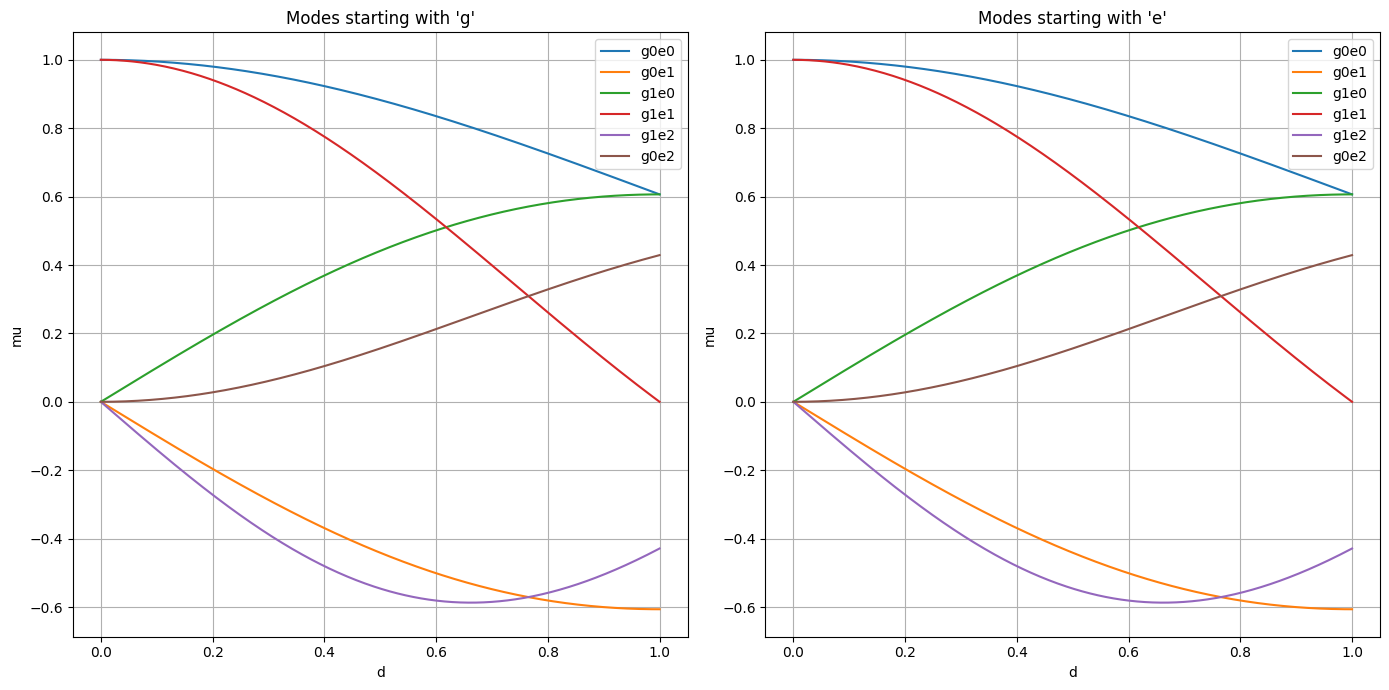

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def dip_plot():
    d_values = np.linspace(0, 1, 500)  # Intervallo di valori per d
    
    # Definire tutti i modi disponibili
    g_modes = ["g0e0", "g0e1", "g1e0", "g1e1", "g1e2", "g0e2"]
    e_modes = ["e0g0", "e0g1", "e1g0", "e1g1", "e2g1", "e2g0"]

    plt.figure(figsize=(14, 7))

    # Plot per i modi che iniziano con 'g'
    plt.subplot(1, 2, 1)
    for mode in g_modes:
        mu_values = [dip(mode, d, 'c') for d in d_values]
        plt.plot(d_values, mu_values, label=mode)
    plt.title("Modes starting with 'g'")
    plt.xlabel("d")
    plt.ylabel("mu")
    plt.legend()
    plt.grid()

    # Plot per i modi che iniziano con 'e'
    plt.subplot(1, 2, 2)
    for mode in g_modes:
        mu_values = [dip(mode, d, 'a') for d in d_values]
        plt.plot(d_values, mu_values, label=mode)
    plt.title("Modes starting with 'e'")
    plt.xlabel("d")
    plt.ylabel("mu")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

dip_plot()
